In [102]:
# Set plot sizes
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [103]:
# Imports
import math

# Pandas for managing datasets
import pandas as pd

# Numpy
import numpy as np

# Matplotlib for additional customization
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

# File path operations etc
import glob

# Regexes
import re

# Show SVG figures
from IPython.display import set_matplotlib_formats

In [104]:
# Show SVG figures
set_matplotlib_formats('svg')

# Plot config
plt.rcParams["axes.grid.axis"] ="y"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (5,9)

# Paper size
sns.set_context('paper', font_scale=1.2, rc={"lines.linewidth": 2}) 

In [105]:
# Legend names
cpu_baseline_name = 'CPU baseline'
gpu_baseline_name = 'GPU baseline'
boruvka_naive_name = 'Boruvka Felz.'
boruvka_naive_dynamic_name = 'Boruvka Felz. Dyn.'
fast_mst_hierarchy_name = 'Fast MST Hier.'
segmentation_hierarchy_name = 'Segmentation Hier.'
fast_superpixel_hierarchy_name = 'Fast Superpixel Hier.'

# Color palette
palette = {
    cpu_baseline_name: '#e41a1c',
    gpu_baseline_name: '#377eb8',
    boruvka_naive_name: '#4daf4a',
    boruvka_naive_dynamic_name: '#ff7f00',
    fast_mst_hierarchy_name: '#a65628',
    segmentation_hierarchy_name: '#f781bf',
    fast_superpixel_hierarchy_name: '#999999'
}

In [124]:
def plot(mydat, x_logscale, y_logscale, per_pixel, labels, labeltext, right_offset):
    f, ax = plt.subplots()
    plot_data = mydat.copy()
    y_label = 'time (µs)'
    x_label = 'pixels'

    if per_pixel:
        plot_data["time (µs)"] = plot_data["time (µs)"] / plot_data["pixels"]
        plot_data.rename(columns = {'time (µs)':'time/pixel (µs)'}, inplace = True) 
        y_label = 'time/pixel (µs)'
        
    if x_logscale:
        plot_data['pixels_log'] = np.log2(plot_data['pixels'])
        x_label = 'pixels_log'
    
    g = sns.lineplot(
        data=plot_data,
        x=x_label, y=y_label, hue="algorithm",marker='.', markersize=10, palette=palette, ci='sd', estimator="mean"
    )
    #g.set_title(title)
    
    if y_logscale:
        g.set_yscale('log', base=2)
        
    # Legend to top
    plt.legend(bbox_to_anchor=(right_offset,1.09,1-right_offset,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, handlelength=1.1, fontsize=9.4)
        
    # Set x ticks
    g.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());
    g.set_xticks(sorted(plot_data[x_label][:].unique()));
    g.set_xticklabels(labels, rotation=0);

    # No x label
    g.set(xlabel=None)
    
    # Set label text and reposition
    g.set_ylabel(labeltext, rotation=0, horizontalalignment='left')
    g.yaxis.set_label_coords(right_offset,1.02)
    g.set_ylim(bottom=0)
    
    # Remove spines
    sns.despine(bottom=False, left=False, ax=g)

In [125]:
def add_data(filespath, algo_name):
    all_files = glob.glob(filespath + "/*.csv")
    li = []
    for filename in all_files:
        # Extract number of pixels
        filename_search = re.search('.*_(.*)_(.*)\.csv', filename)
        n_rows = int(filename_search.group(1))
        n_cols = int(filename_search.group(2))
        pixels = n_rows * n_cols

        # Read csv and add number of pixels
        df = pd.read_csv(filename)
        df['pixels'] = pixels
        df['algorithm'] = algo_name
        li.append(df)
    
    # Merge all csv files
    myframe = pd.concat(li, axis=0, ignore_index=True)
    return myframe

In [126]:
# Read partial plots data
partial_list = []

partial_list.append(add_data('./bench_results/cpu_baseline/bench_results_partial/', cpu_baseline_name))
partial_list.append(add_data('./bench_results/gpu_baseline/bench_results_partial/', gpu_baseline_name))
partial_list.append(add_data('./bench_results/cuda_mst_naive/bench_results_partial/', boruvka_naive_name))
partial_list.append(add_data('./bench_results/cuda_mst_naive_dynpar/bench_results_partial/', boruvka_naive_dynamic_name))
partial_list.append(add_data('./bench_results/fastmst_segment/bench_results_partial/', fast_mst_hierarchy_name))
partial_list.append(add_data('./bench_results/boruvka_fastmst/bench_results_partial/', segmentation_hierarchy_name))
partial_list.append(add_data('./bench_results/superpixel/bench_results_partial/', fast_superpixel_hierarchy_name))

partial_frame = pd.concat(partial_list, axis=0, ignore_index=True)
partial_frame.rename(columns=lambda x: x.strip(), inplace=True)

# Extracts parts out of partial frames for plotting
newframe = partial_frame.melt(id_vars=['pixels', 'algorithm'], var_name='part', value_name='time (µs)')

gaussian_frame = newframe.loc[newframe['part'] == 'gaussian']
graph_frame = newframe.loc[newframe['part'] == 'graph']
segmentation_frame = newframe.loc[newframe['part'] == 'segmentation']
output_frame = newframe.loc[newframe['part'] == 'output']

In [127]:
# Read total plots data
total_list = []

total_list.append(add_data('./bench_results/cpu_baseline/bench_results/', cpu_baseline_name))
total_list.append(add_data('./bench_results/gpu_baseline/bench_results/', gpu_baseline_name))
total_list.append(add_data('./bench_results/cuda_mst_naive/bench_results/', boruvka_naive_name))
total_list.append(add_data('./bench_results/cuda_mst_naive_dynpar/bench_results/', boruvka_naive_dynamic_name))
total_list.append(add_data('./bench_results/fastmst_segment/bench_results/', fast_mst_hierarchy_name))
total_list.append(add_data('./bench_results/boruvka_fastmst/bench_results/', segmentation_hierarchy_name))
total_list.append(add_data('./bench_results/superpixel/bench_results/', fast_superpixel_hierarchy_name))

total_frame = pd.concat(total_list, axis=0, ignore_index=True)
total_frame.rename(columns=lambda x: x.strip(), inplace=True)
total_frame.rename(columns={'total': 'time (µs)'}, inplace=True)

In [128]:
# Reduce frames to start from 960x540
reduced_total_frame = total_frame[total_frame['pixels'] >= (960 * 540)]

reduced_gaussian_frame = gaussian_frame[gaussian_frame['pixels'] >= (960 * 540)]
reduced_graph_frame  = graph_frame[graph_frame['pixels'] >= (960 * 540)]
reduced_segmentation_frame  = segmentation_frame[segmentation_frame['pixels'] >= (960 * 540)]
reduced_output_frame = output_frame[output_frame['pixels'] >= (960 * 540)]

/Users/amoryhoste/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


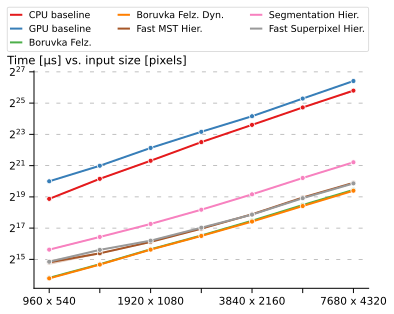

In [145]:
# Plot total runtime
reduced_labels = ['960 x 540', '', '1920 x 1080', '', "3840 x 2160", '', '7680 x 4320']
plot(reduced_total_frame, x_logscale=True, y_logscale=True, per_pixel=False, labels=reduced_labels, labeltext='Time [µs] vs. input size [pixels]', right_offset=-0.08)
plt.savefig("total_loglog.pdf",bbox_inches='tight', pad_inches = 0.01)

/Users/amoryhoste/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


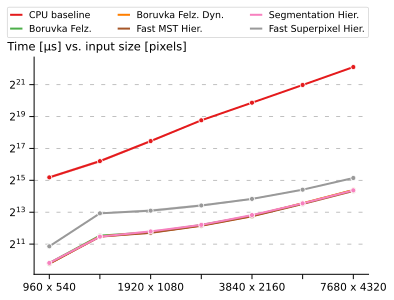

In [146]:
# Plot filtering runtime (gaussian + sobel / gaussian)
reduced_labels = ['960 x 540', '', '1920 x 1080', '', "3840 x 2160", '', '7680 x 4320']
plot(reduced_gaussian_frame.loc[~reduced_gaussian_frame['algorithm'].isin([gpu_baseline_name])], x_logscale=True, y_logscale=True, per_pixel=False, labels=reduced_labels, labeltext='Time [µs] vs. input size [pixels]', right_offset=-0.08)
plt.savefig("filter_loglog.pdf",bbox_inches='tight', pad_inches = 0.01)

/Users/amoryhoste/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


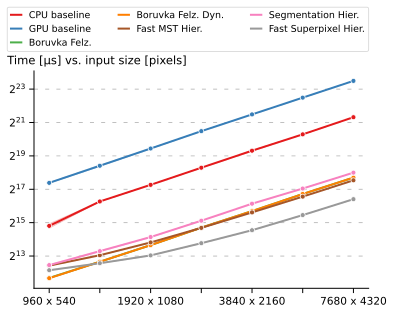

In [147]:
# Plot Graph Creation runtime
reduced_labels = ['960 x 540', '', '1920 x 1080', '', "3840 x 2160", '', '7680 x 4320']
plot(reduced_graph_frame, x_logscale=True, y_logscale=True, per_pixel=False, labels=reduced_labels, labeltext='Time [µs] vs. input size [pixels]', right_offset=-0.08)
plt.savefig("graph_loglog.pdf",bbox_inches='tight', pad_inches = 0.01)

/Users/amoryhoste/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


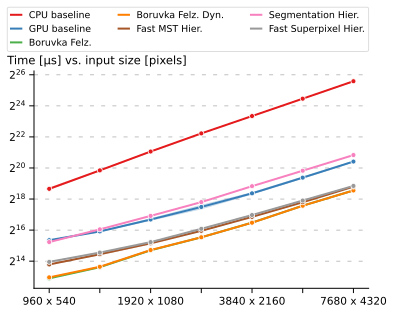

In [148]:
# Plot Segmentation runtime
reduced_labels = ['960 x 540', '', '1920 x 1080', '', "3840 x 2160", '', '7680 x 4320']
plot(reduced_segmentation_frame, x_logscale=True, y_logscale=True, per_pixel=False, labels=reduced_labels, labeltext='Time [µs] vs. input size [pixels]', right_offset=-0.08)
plt.savefig("segmentation_loglog.pdf",bbox_inches='tight', pad_inches = 0.01)

/Users/amoryhoste/.pyenv/versions/3.7.9/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


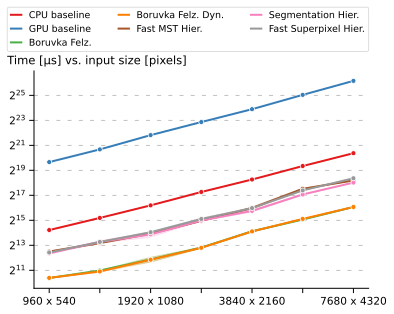

In [149]:
# Plot Output runtime
reduced_labels = ['960 x 540', '', '1920 x 1080', '', "3840 x 2160", '', '7680 x 4320']
plot(reduced_output_frame, x_logscale=True, y_logscale=True, per_pixel=False, labels=reduced_labels, labeltext='Time [µs] vs. input size [pixels]', right_offset=-0.08)
plt.savefig("output_loglog.pdf",bbox_inches='tight', pad_inches = 0.01)

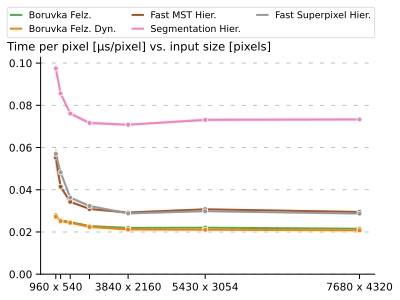

In [150]:
# Plot total runtime without baselines
reduced_labels = ['960 x 540', '', '', '', "3840 x 2160", '5430 x 3054', '7680 x 4320']
plot(reduced_total_frame.loc[~reduced_total_frame['algorithm'].isin([gpu_baseline_name, cpu_baseline_name])], x_logscale=False, y_logscale=False, per_pixel=True, labels=reduced_labels, labeltext='Time per pixel [µs/pixel] vs. input size [pixels]', right_offset=-0.1)
plt.savefig("total_nobaseline_perpixel.pdf",bbox_inches='tight', pad_inches = 0.01)

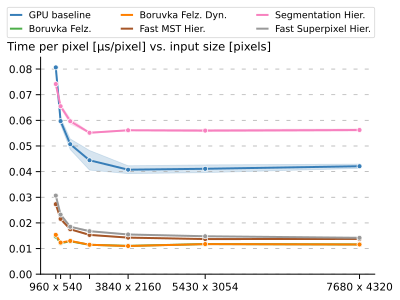

In [153]:
# Plot segmentation runtime without cpu baseline
reduced_labels = ['960 x 540', '', '', '', "3840 x 2160", '5430 x 3054', '7680 x 4320']
plot(reduced_segmentation_frame.loc[~reduced_segmentation_frame['algorithm'].isin([cpu_baseline_name])], x_logscale=False, y_logscale=False, per_pixel=True, labels=reduced_labels, labeltext='Time per pixel [µs/pixel] vs. input size [pixels]', right_offset=-0.1)
plt.savefig("segment_nocpu_perpixel.pdf",bbox_inches='tight', pad_inches = 0.01)

In [152]:
# Make titles correct depending on per pixel or not!